# Solving Hamilton-Jacobi-Bellman PDE with Physically-Informed Neural Networks

Where should I start? Hmmm. Quadratic Programming is the way to go. Yeah, let's start with that.

https://www.cds.caltech.edu/~murray/courses/cds110/wi06/lqr.pdf

This problem has an explicit solution, so it's a good way to see how good the PINN is of solving it.
TODO

- solve explicitly according to the notes above
- solve with PINN and compare with optimal solution

It's a good first step.

In [44]:
import numpy as np
from scipy.integrate import simpson
import matplotlib.pyplot as plt

In [35]:
# Final time
T = 1
# Number of points in the discretization
N = 100
# Step size
h = T / N

# System matrices
# Q, R and P1 need to be symmetric and positive semidefinite (definite for R)
A = np.array([[1]])
B = np.array([[0.1]])
Q = np.array([[1]])
R = np.array([[1]])
Rinv = np.linalg.inv(R)
P1 = np.array([[1]])

In [36]:
# Total cost function that we want to minimize
def total_cost(x: np.ndarray, u: np.ndarray, h: float) -> float:
	# Integral of the cost function
	cumulative_cost = np.sum(simpson(x.T @ Q @ x + u.T @ R @ u, dx=h))
	# Fixed cost at the final time
	fixed_cost = 0.5 * x(T).T @ P1 @ x(T)
	return cumulative_cost + fixed_cost

In [37]:
# Dynamics of the system
def linear_dynamics(x: np.ndarray, u: np.ndarray) -> np.ndarray:
	return A @ x + B @ u

In [38]:
def reverse_time_ricatti_equation(P: np.ndarray) -> np.ndarray:
	# ODE from caltech notes
	# Note that we only have a final condition for P, not an initial condition
	# So we need to solve the ODE backwards in time
	return P @ A + A.T @ P + Q - P @ B @ Rinv @ B.T @ P

In [39]:
def RK_method(F, x0, h, n_steps, a, b):
    dim = len(x0)
    l = len(b)
    x = np.zeros((n_steps, dim))
    x[0] = x0
    k = np.zeros((l, dim))

    for n in range(1, n_steps):
        k[0] = F(x[n - 1])
        for i in range(1, l):
            x_i = x[n - 1] + h * np.dot(a[i - 1][:i], k[:i])
            k[i] = F(x_i)
        x[n] = x[n - 1] + h * np.dot(b, k)

    return x

# Classical (4-stage) Runge-Kutta
a = np.array(
        [[0.5, 0, 0],
         [0, 0.5, 0],
         [0, 0, 1]]
    )
b = np.array([1 / 6, 2 / 6, 2 / 6, 1 / 6])

def RK4(F, x0, h, n_steps):
    return RK_method(F, x0, h, n_steps, a, b)

First we solve the Riccati ODE. Then we can use it to solve the linear-quadratic regulator.

In [47]:
reverse_time_P = RK4(reverse_time_ricatti_equation, P1, h, N)
P = reverse_time_P[::-1]

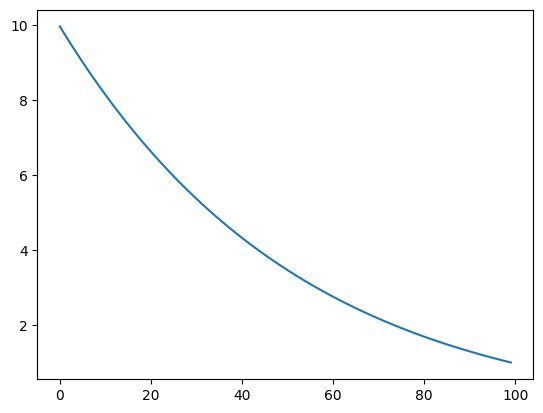

In [48]:
plt.plot(P)